<a href="https://colab.research.google.com/github/MosheWasserb/PyTorchNotbooks/blob/master/IPS_Chalenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Visual Notebook to Using BERT for the First TIme.ipynb



<img src="https://jalammar.github.io/images/distilBERT/bert-distilbert-sentence-classification.png" />

In this notebook, we will use pre-trained deep learning model to process some text. We will then use the output of that model to classify the text. The text is a list of sentences from film reviews. And we will calssify each sentence as either speaking "positively" about its subject of "negatively".

## Models: Sentence Sentiment Classification
Our goal is to create a model that takes a sentence (just like the ones in our dataset) and produces either 1 (indicating the sentence carries a positive sentiment) or a 0 (indicating the sentence carries a negative sentiment). We can think of it as looking like this:

<img src="https://jalammar.github.io/images/distilBERT/sentiment-classifier-1.png" />

Under the hood, the model is actually made up of two model.

* DistilBERT processes the sentence and passes along some information it extracted from it on to the next model. DistilBERT is a smaller version of BERT developed and open sourced by the team at HuggingFace. It’s a lighter and faster version of BERT that roughly matches its performance.
* The next model, a basic Logistic Regression model from scikit learn will take in the result of DistilBERT’s processing, and classify the sentence as either positive or negative (1 or 0, respectively).

The data we pass between the two models is a vector of size 768. We can think of this of vector as an embedding for the sentence that we can use for classification.


<img src="https://jalammar.github.io/images/distilBERT/distilbert-bert-sentiment-classifier.png" />

## Dataset
The dataset we will use in this example is [SST2](https://nlp.stanford.edu/sentiment/index.html), which contains sentences from movie reviews, each labeled as either positive (has the value 1) or negative (has the value 0):


<table class="features-table">
  <tr>
    <th class="mdc-text-light-green-600">
    sentence
    </th>
    <th class="mdc-text-purple-600">
    label
    </th>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      a stirring , funny and finally transporting re imagining of beauty and the beast and 1930s horror films
    </td>
    <td class="mdc-bg-purple-50">
      1
    </td>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      apparently reassembled from the cutting room floor of any given daytime soap
    </td>
    <td class="mdc-bg-purple-50">
      0
    </td>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      they presume their audience won't sit still for a sociology lesson
    </td>
    <td class="mdc-bg-purple-50">
      0
    </td>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      this is a visually stunning rumination on love , memory , history and the war between art and commerce
    </td>
    <td class="mdc-bg-purple-50">
      1
    </td>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      jonathan parker 's bartleby should have been the be all end all of the modern office anomie films
    </td>
    <td class="mdc-bg-purple-50">
      1
    </td>
  </tr>
</table>

## Installing the transformers library
Let's start by installing the huggingface transformers library so we can load our deep learning NLP model.

In [0]:
!pip install transformers

     |████████████████████████████████| 573kB 3.3MB/s 
     |████████████████████████████████| 3.7MB 16.9MB/s 
     |████████████████████████████████| 1.0MB 37.2MB/s 
     |████████████████████████████████| 870kB 52.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=4037c5ac06680f1b837d7b67a71db264ea1d7aff280ee41fd38ee28d8065d7ea
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses


In [0]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import time
from sklearn import preprocessing
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.preprocessing import LabelEncoder
from IPython.display import clear_output
from torch.nn.utils import clip_grad_norm_
from sklearn.linear_model import LinearRegression

### Helper functions
import pickle

def convert_to_pickle(item, directory):
    pickle.dump(item, open(directory,"wb"))


def load_from_pickle(directory):
    return pickle.load(open(directory,"rb"))

## Importing the dataset
We'll use pandas to read the dataset and load it into a dataframe.

In [0]:
### read data from your Google Drive
from google.colab import drive
drive.mount('/gdrive')



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
# load data
#data = pd.read_csv(r"/gdrive/My Drive/Colab Notebooks/DAIR/EmotionDataSet/multiclass6ed.csv")
#data.emotions.value_counts().plot.bar()


data=pd.read_csv(r"/gdrive/My Drive/IL/ips.csv")


,Case ID,Subject,Case Description,Case Category,Case Subcategory,Product Type,Product Organization: Support Org Name,Product Name
0,5001J00000aBjFH,Other Licensing Issue,Error Msg : \nPO#: \nLAC/SN: aeff9593\nHOST ID...,Design Tools,Installation / Licensing,NaN,Programmable Solutions Group,Licensed Products
1,5001J00000aDDRH,CANON ICB Common PF : Leaf_Hill_CRB_Schematics...,"Hello,\nPlease answer the following customer's...",Hardware,Documentation,NaN,Embedded Products,Apollo Lake
2,5001J00000Vdd0A,Intel DCG_Lake_Wanaka: Request to get the late...,"Error Msg : \nHi there,\nWhere I can get the l...",Design Tools,Installation / Licensing,NaN,Programmable Solutions Group,Intel® Stratix® 10 GX FPGA
3,5001J00000ch1bO,Testing please ignore INC008079049,Testing INC008079049\nplease ignore,Test/Validation,Other,Server Products,Server Platforms,Intel® Server System ASB2224WFAFP2
4,5001J00000aCzh6,Need help translation IBIS models to Quartus S...,Error Msg : \nSignal Integrity Analysis has de...,Design Tools,Design Entry/Synthesis & Netlist Viewers,NaN,Programmable Solutions Group,Cyclone® V GX FPGA


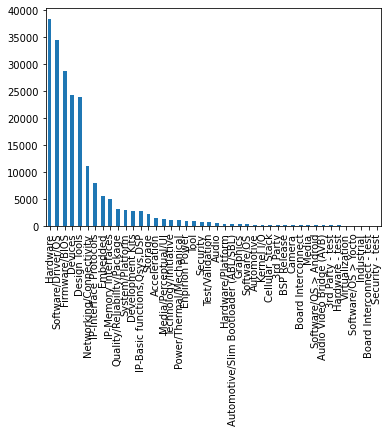

In [0]:
# First col & second col should be text and category 
text_col=data.columns.values[2] 
category_col=data.columns.values[3]

data[category_col].value_counts().plot.bar()

In [0]:
data_filter= data[data[category_col].isin(data[category_col].value_counts()[data[category_col].value_counts()>10000].index)]

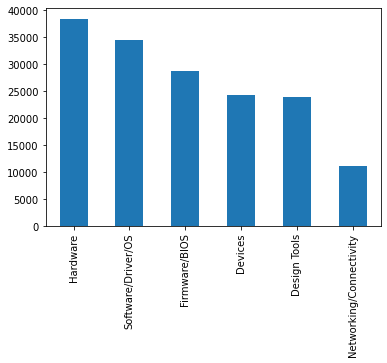

In [0]:
data_filter[category_col].value_counts()
data_filter[category_col].value_counts().plot.bar()


For performance reasons, we'll only use 2,000 sentences from the dataset

In [0]:
batch_1 = data.sample(n=8000, random_state=42);

We can ask pandas how many sentences are labeled as "positive" (value 1) and how many are labeled "negative" (having the value 0)

In [0]:
batch_1.head(5)

,Case ID,Subject,Case Description,Case Category,Case Subcategory,Product Type,Product Organization: Support Org Name,Product Name
31347,5001J00000kDJZa,[HPE-TDCA2000+] PCH(LBG) PCIE3 TX Compliance T...,After turned on lane pattern generator in IPLE...,Hardware,Electrical Validation (EV),Server Products,Data Center,Whitley
30593,500o000000QvLWS,The RSC / IPV4 / TCP / UDP offload function of...,Dear Bruce and Daphne :\n PHY Board enable...,Networking/Connectivity,Ethernet/Wired LAN,Ethernet Products,Data Center,Sageville
89028,5001J00000chB46,{NEC] Stratix V Transceiver CDR部の機能について,Error Msg : \n日本アルテラ 安間様\n牧田@NEC放メ・二技です。\n下記の点...,Devices,Transceiver,NaN,Programmable Solutions Group,Stratix® V GX FPGA
59925,500o000000GxD0B,Client cannot uninstall Unite app from control...,Client cannot uninstall app from the control p...,Software/Driver/OS,Intel® Unite™,"Processors, Chipsets",Client Computing,Skylake
172455,500o000000NgatY,XEON D 1500 Board Bring Up,"Hello,\nWe are trying to bring up our XEON D 1...",Firmware/BIOS,BIOS,NaN,Data Center,Grangeville


## Loading the Pre-trained BERT model
Let's now load a pre-trained BERT model. 

In [0]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## Want BERT instead of distilBERT? Uncomment the following line:
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

## Want Roberta instead of distilBERT? Uncomment the following line:
#model_class, tokenizer_class, pretrained_weights = (ppb.RobertaModel, ppb.RobertaTokenizer, 'roberta-base')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
BertModel = model_class.from_pretrained(pretrained_weights)

Right now, the variable `model` holds a pretrained distilBERT model -- a version of BERT that is smaller, but much faster and requiring a lot less memory.

## Model #1: Preparing the Dataset
Before we can hand our sentences to BERT, we need to so some minimal processing to put them in the format it requires.

### Tokenization
Our first step is to tokenize the sentences -- break them up into word and subwords in the format BERT is comfortable with.

In [0]:
tokenized = batch_1[text_col].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

Token indices sequence length is longer than the specified maximum sequence length for this model (3143 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (812 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1158 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (944 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (659 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

<img src="https://jalammar.github.io/images/distilBERT/bert-distilbert-tokenization-2-token-ids.png" />

### Padding
After tokenization, `tokenized` is a list of sentences -- each sentences is represented as a list of tokens. We want BERT to process our examples all at once (as one batch). It's just faster that way. For that reason, we need to pad all lists to the same size, so we can represent the input as one 2-d array, rather than a list of lists (of different lengths).

In [0]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

Our dataset is now in the `padded` variable, we can view its dimensions below:

In [0]:
np.array(padded).shape

(8000, 16857)

### Masking
If we directly send `padded` to BERT, that would slightly confuse it. We need to create another variable to tell it to ignore (mask) the padding we've added when it's processing its input. That's what attention_mask is:

In [0]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(8000, 16857)

Convert to tensors

In [0]:
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

## Model #1: And Now, Deep Learning!
Now that we have our model and inputs ready, let's run our model!

<img src="http://127.0.0.1:4000/images/distilBERT/bert-distilbert-tutorial-sentence-embedding.png" />

The `model()` function runs our sentences through BERT. The results of the processing will be returned into `last_hidden_states`.

In [0]:
start = time.time()


with torch.no_grad():
    last_hidden_states = BertModel(input_ids, attention_mask=attention_mask)

print('Time taken for convert tokens to BERT vectos in sec {} \n'.format(time.time() - start))

Time taken for convert tokens to BERT vectos in sec 67.54479217529297 



Let's slice only the part of the output that we need. That is the output corresponding the first token of each sentence. The way BERT does sentence classification, is that it adds a token called `[CLS]` (for classification) at the beginning of every sentence. The output corresponding to that token can be thought of as an embedding for the entire sentence.

<img src="https://jalammar.github.io/images/distilBERT/bert-output-tensor-selection.png" />

We'll save those in the `features` variable, as they'll serve as the features to our logitics regression model.

In [0]:
features = last_hidden_states[0][:,0,:].numpy()

The labels indicating which sentence is positive and negative now go into the `labels` variable

In [0]:
labels = batch_1[category_col]

## Model #2: Train/Test Split
Let's now split our datset into a training set and testing set (even though we're using 2,000 sentences from the SST2 training set).

Splite features and text with the same seed

In [0]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels,test_size=0.2,random_state=42)

In [0]:
test_features

array([[ 0.02563108,  0.05002639, -0.1903948 , ..., -0.09171991,
         0.3833878 ,  0.29440573],
       [ 0.128642  , -0.0040712 , -0.03010212, ..., -0.08118317,
         0.26797116,  0.23729531],
       [ 0.11033169,  0.18332395, -0.0576109 , ..., -0.02182874,
         0.44140986,  0.37397784],
       ...,
       [-0.12950045,  0.0923728 , -0.14527327, ...,  0.03483703,
         0.31825507,  0.10476423],
       [ 0.03076752,  0.17785792, -0.01049792, ..., -0.11325731,
         0.5243633 ,  0.38401675],
       [ 0.03822049,  0.12644139,  0.01217839, ..., -0.09107625,
         0.32295817,  0.44957423]], dtype=float32)

In [0]:
train_texts, test_texts = train_test_split(batch_1[text_col],test_size=0.2,random_state=42)

In [0]:
train_token_tensor, test_token_tensor, train_mask_tensor, test_mask_tensor = train_test_split(input_ids,attention_mask,test_size=0.2,random_state=42)

<img src="http://127.0.0.1:4000/images/distilBERT/bert-distilbert-train-test-split-sentence-embedding.png" />

### [Bonus] Grid Search for Parameters
We can dive into Logistic regression directly with the Scikit Learn default parameters, but sometimes it's worth searching for the best value of the C parameter, which determines regularization strength.

In [0]:
 #parameters = {'C': np.linspace(0.0001, 100, 20)}
 #grid_search = GridSearchCV(LogisticRegression(), parameters)
 #grid_search.fit(train_features, train_labels)

 #print('best parameters: ', grid_search.best_params_)
 #print('best scrores: ', grid_search.best_score_)

best parameters:  {'C': 5.263252631578947}
best scrores:  0.5479999999999999


We now train the LogisticRegression model. If you've chosen to do the gridsearch, you can plug the value of C into the model declaration (e.g. `LogisticRegression(C=5.2)`).

<img src="http://127.0.0.1:4000/images/distilBERT/bert-training-logistic-regression.png" />

## Evaluating Model #2
So how well does our model do in classifying sentences? One way is to check the accuracy against the testing dataset:

In [0]:
lr_clf = LogisticRegression()
lr_baseline_model=lr_clf.fit(train_features, train_labels)
lr_baseline_predicted = lr_baseline_model.predict(test_features)
print(classification_report(test_labels, lr_baseline_predicted))

              precision    recall  f1-score   support

       anger       0.52      0.38      0.44       229
        fear       0.49      0.48      0.49       175
         joy       0.63      0.77      0.70       517
        love       0.35      0.13      0.19       129
     sadness       0.59      0.69      0.64       485
    surprise       0.47      0.12      0.20        65

    accuracy                           0.58      1600
   macro avg       0.51      0.43      0.44      1600
weighted avg       0.56      0.58      0.56      1600



In [0]:
lr_clf.score(test_features, test_labels)

0.58125

How good is this score? What can we compare it against? Let's first look at a dummy classifier:

In [0]:
from sklearn.dummy import DummyClassifier
clf = DummyClassifier()

scores = cross_val_score(clf, train_features, train_labels)
print("Dummy classifier score: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Dummy classifier score: 0.242 (+/- 0.01)


Comare to simple baseline bi-gram count model

In [0]:
ngramCount_baseline_model = make_pipeline(CountVectorizer(ngram_range=(1,3)), LogisticRegression()).fit(train_texts, train_labels)
ngramCount_baseline_predicted = ngramCount_baseline_model.predict(test_texts)
print(classification_report(test_labels, ngramCount_baseline_predicted))

                         precision    recall  f1-score   support

           Design Tools       0.84      0.75      0.79       246
                Devices       0.77      0.79      0.78       222
          Firmware/BIOS       0.63      0.59      0.61       274
               Hardware       0.66      0.82      0.73       405
Networking/Connectivity       0.64      0.35      0.45       120
     Software/Driver/OS       0.67      0.66      0.67       333

               accuracy                           0.70      1600
              macro avg       0.70      0.66      0.67      1600
           weighted avg       0.70      0.70      0.69      1600



So our model clearly does better than a dummy classifier. But how does it compare against the best models?

## Proper SST2 scores
For reference, the [highest accuracy score](http://nlpprogress.com/english/sentiment_analysis.html) for this dataset is currently **96.8**. DistilBERT can be trained to improve its score on this task – a process called **fine-tuning** which updates BERT’s weights to make it achieve a better performance in this sentence classification task (which we can call the downstream task). The fine-tuned DistilBERT turns out to achieve an accuracy score of **90.7**. The full size BERT model achieves **94.9**.



And that’s it! That’s a good first contact with BERT. The next step would be to head over to the documentation and try your hand at [fine-tuning](https://huggingface.co/transformers/examples.html#glue). You can also go back and switch from distilBERT to BERT and see how that works.

**BERT Fine Tune**

### 2.1 Init


In [0]:
BATCH_SIZE=64
EPOCHS =10
HIDDEN_SIZE=768

#emotions=list(set(batch_1.emotions.unique()))
catagories=list(set(data[category_col].unique()))
OUTPUT_DIM= len(catagories)   #num of catagories

### 2.1 Binarization
We would like to binarize our target so that we can obtain one-hot encodings as target values. These are easier and more efficient to work with and will be useful when training the models.

In [0]:
mlb = preprocessing.MultiLabelBinarizer()
data_labels =  [set(catos) & set(catagories) for catos in batch_1[[category_col]].values]
bin_catagories = mlb.fit_transform(data_labels)
target_tensor_bin = torch.tensor(bin_catagories.tolist())

In [0]:
target_tensor=torch.max(target_tensor_bin,1)[1]

### 2.1 Tranform labels to float
We would like to binarize our target so that we can obtain one-hot encodings as target values. These are easier and more efficient to work with and will be useful when training the models.

In [0]:
#target_num_tensor2=torch.tensor(LabelEncoder().fit_transform(batch_1['emotions']))
#target_tensor2 = target_num_tensor2.reshape(-1,1).float()

In [0]:
target_tensor2[0:2]

NameError: ignored

In [0]:
from torch.utils.data import Dataset, DataLoader

### 2.2 Convert to tensors


In [0]:
train_tokens_tensor, test_tokens_tensor, train_masks_tensor, test_masks_tensor = train_test_split(input_ids,attention_mask,test_size=0.2,random_state=42)
train_y_tensor, test_y_tensor  = train_test_split(target_tensor,test_size=0.2,random_state=42)

### 2.3 Build DataLoader


In [0]:
train_dataset = TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

test_dataset = TensorDataset(test_tokens_tensor, test_masks_tensor, test_y_tensor)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

### 2.4 Define Model 


In [0]:
class BertMultiClassifier(torch.nn.Module):
    def __init__(self, dropout=0.1):
        super(BertMultiClassifier, self).__init__()
        # Need to define the right layer 
        self.bert = model_class.from_pretrained(pretrained_weights)
        #self.dropout = torch.nn.Dropout(dropout)
        self.linear = torch.nn.Linear(HIDDEN_SIZE, OUTPUT_DIM)
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self, input_ids, attention_mask):
        last_hidden_states = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = last_hidden_states[0][:,0,:]
        #dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(pooled_output)
        proba = self.sigmoid(linear_output)
        return linear_output

### 2.5 BERT Fine tune Training 


In [0]:
bert_clf = BertMultiClassifier()
optimizer = torch.optim.Adam(bert_clf.parameters(), lr=3e-6)
criterion = torch.nn.CrossEntropyLoss() # the same as log_softmax + NLLLoss.  Check BCEWithLogitsLoss()

In [0]:
losses = []
steps = []
step = 0
for epoch_num in range(EPOCHS):
    bert_clf.train()
    train_loss = 0
    for step_num, batch_data in enumerate(train_dataloader):
        token_ids, masks, labels = tuple(t for t in batch_data)
        probas = bert_clf(token_ids, masks)
        
        batch_loss = criterion(probas, labels)
        train_loss += batch_loss.item()
        
        
        bert_clf.zero_grad()
        batch_loss.backward()
        

        #clip_grad_norm_(parameters=bert_clf.parameters(), max_norm=1.0)
        optimizer.step()
        
        clear_output(wait=True)
        print('Epoch: ', epoch_num + 1)
        print("{0}/{1} loss: {2} ".format(step_num, len(train_y_tensor) / BATCH_SIZE, train_loss / (step_num + 1)))
        losses.append(batch_loss.item())
        steps.append(step)
        step += 1

#convert_to_pickle(bert_clf, "/gdrive/My Drive/Colab Notebooks/DAIR/EmotionDataSet/DistilBERTfineTune6400tr10epochs.pkl")

Epoch:  1
1/100.0 loss: 1.9223171472549438 


KeyboardInterrupt: ignored

### 2.6 Evaluation 


In [0]:
bert_clf.eval()
bert_predicted = []
all_logits = []
with torch.no_grad():
    for step_num, batch_data in enumerate(test_dataloader):

        token_ids, masks, labels = tuple(t for t in batch_data)

        probas = bert_clf(token_ids, masks)
        
        bert_predicted += list(torch.max(probas,1)[1])

In [0]:
print(classification_report(test_y_tensor, bert_predicted))

              precision    recall  f1-score   support

           0       0.94      0.91      0.93       229
           1       0.82      0.90      0.86       175
           2       0.91      0.91      0.91       517
           3       0.75      0.76      0.75       129
           4       0.95      0.96      0.95       485
           5       0.87      0.71      0.78        65

    accuracy                           0.90      1600
   macro avg       0.87      0.86      0.86      1600
weighted avg       0.90      0.90      0.90      1600



In [0]:
print(classification_report(test_y_tensor, bert_predicted))

              precision    recall  f1-score   support

           0       0.94      0.91      0.93       229
           1       0.82      0.90      0.86       175
           2       0.91      0.91      0.91       517
           3       0.75      0.76      0.75       129
           4       0.95      0.96      0.95       485
           5       0.87      0.71      0.78        65

    accuracy                           0.90      1600
   macro avg       0.87      0.86      0.86      1600
weighted avg       0.90      0.90      0.90      1600



In [0]:
print(confusion_matrix(test_y_tensor, bert_predicted))

[[169  14   4   4  38   0]
 [  7 142   3   0  20   3]
 [  7   5 431  48  24   2]
 [  1   2  35  84   7   0]
 [  1  18  12   5 449   0]
 [  0  16   7   1   6  35]]


**Logistic Distilation with BERT**

Need to define class BertMultiClass

In [0]:
class BertMultiClassifier(torch.nn.Module):
    def __init__(self, dropout=0.1):
        super(BertMultiClassifier, self).__init__()
        # Need to define the right layer 
        self.bert = model_class.from_pretrained(pretrained_weights)
        #self.dropout = torch.nn.Dropout(dropout)
        self.linear = torch.nn.Linear(HIDDEN_SIZE, OUTPUT_DIM)
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self, input_ids, attention_mask):
        last_hidden_states = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = last_hidden_states[0][:,0,:]
        #dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(pooled_output)
        proba = self.sigmoid(linear_output)
        return linear_output

In [0]:
bert_clf = load_from_pickle("/gdrive/My Drive/Colab Notebooks/DAIR/EmotionDataSet/DistilBERTfineTune6400tr5epochs.pkl")

Bimarization of lables and create target_tensor

In [0]:
#emotions=list(set(batch_1.emotions.unique()))
catagories=list(set(data[category_col].unique()))

mlb = preprocessing.MultiLabelBinarizer()
data_labels =  [set(catos) & set(catagories) for catos in batch_1[[category_col]].values]
bin_catagories = mlb.fit_transform(data_labels)
target_tensor_bin = torch.tensor(bin_catagories.tolist())

In [0]:
target_tensor=torch.max(target_tensor_bin,1)[1]

In [0]:
BATCH_SIZE=64
train_tokens_tensor, test_tokens_tensor, train_masks_tensor, test_masks_tensor = train_test_split(input_ids,attention_mask,test_size=0.2,random_state=42)
train_y_tensor, test_y_tensor  = train_test_split(target_tensor,test_size=0.2,random_state=42)

train_dataset_for_distill = TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
train_dataloader_for_distill = DataLoader(train_dataset_for_distill, batch_size=BATCH_SIZE)

In [0]:
bert_clf.eval()
train_logits = []
bert_predicted = []
with torch.no_grad():
    for step_num, batch_data in enumerate(train_dataloader_for_distill):

        token_ids, masks, labels = tuple(t for t in batch_data)

        logits = bert_clf(token_ids, masks)
        
        train_logits += list(logits)

        bert_predicted += list(torch.max(logits,1)[1])

#train_logits = np.vstack(train_logits)

In [0]:
print(classification_report(train_y_tensor, bert_predicted))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       864
           1       0.92      0.96      0.94       754
           2       0.97      0.96      0.97      2188
           3       0.89      0.89      0.89       498
           4       0.98      0.98      0.98      1866
           5       0.90      0.87      0.88       230

    accuracy                           0.96      6400
   macro avg       0.94      0.94      0.94      6400
weighted avg       0.96      0.96      0.96      6400



**Use regression to predicte Logits**

In [0]:
from sklearn.linear_model import LinearRegression

In [0]:
train_texts, test_texts, train_labels, test_labels = train_test_split(batch_1[text_col],batch_1[category_col], test_size=0.2,random_state=42)

In [0]:
train_logits_numpy= (i.numpy() for i in train_logits)
train_logits = np.vstack(train_logits_numpy)


NameError: ignored

In [0]:
train_logits 

array([[-1.6896763 , -0.5345181 ,  5.1783304 , -1.7711558 , -2.2541738 ,
         0.7234218 ],
       [-1.8258332 , -3.205102  ,  4.873008  , -0.5550477 ,  1.0797815 ,
        -1.4393263 ],
       [-2.2791028 , -2.1062865 ,  5.665677  , -0.75003266, -0.7649366 ,
        -0.8934874 ],
       ...,
       [-1.0118906 , -1.3638008 , -0.13120678, -0.3857909 ,  4.7568655 ,
        -2.6017396 ],
       [ 0.07644066,  4.6670856 , -1.1762648 , -1.2533344 , -2.2330873 ,
         1.7640835 ],
       [-0.9474587 , -2.4521034 ,  5.0374484 , -1.1121345 , -1.3535795 ,
         0.43836874]], dtype=float32)

In [0]:
distilled_model = make_pipeline(CountVectorizer(ngram_range=(1,3)), LinearRegression()).fit(train_texts, train_logits)

In [0]:
distilled_predicted_logits = distilled_model.predict(test_texts)

In [0]:
distilled_bert_predicted=torch.max(torch.tensor(distilled_predicted_logits),1)[1]

In [0]:
print(classification_report(test_y_tensor, distilled_bert_predicted))

              precision    recall  f1-score   support

           0       0.93      0.80      0.86       229
           1       0.81      0.79      0.80       175
           2       0.79      0.94      0.86       517
           3       0.85      0.52      0.64       129
           4       0.88      0.91      0.90       485
           5       0.87      0.52      0.65        65

    accuracy                           0.84      1600
   macro avg       0.86      0.75      0.79      1600
weighted avg       0.85      0.84      0.84      1600



In [0]:
print(classification_report(test_y_tensor, distilled_bert_predicted))

              precision    recall  f1-score   support

           0       0.93      0.80      0.86       229
           1       0.81      0.79      0.80       175
           2       0.79      0.94      0.86       517
           3       0.85      0.52      0.64       129
           4       0.88      0.91      0.90       485
           5       0.87      0.52      0.65        65

    accuracy                           0.84      1600
   macro avg       0.86      0.75      0.79      1600
weighted avg       0.85      0.84      0.84      1600



(array([ 409., 1688.,  705.,  923., 1109.,  574.,  223.,  258.,  273.,
         238.]),
 array([-2.459845  , -1.8476666 , -1.2354882 , -0.6233098 , -0.01113138,
         0.60104704,  1.2132255 ,  1.8254039 ,  2.4375823 ,  3.0497608 ,
         3.6619391 ], dtype=float32),
 <a list of 10 Patch objects>)

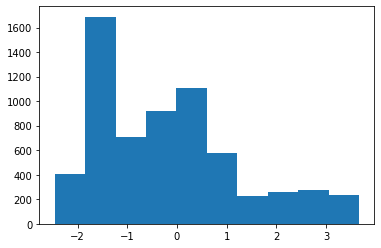

In [0]:
import matplotlib.pyplot as plt
plt.hist(train_logits[:,0])

**Use unlabeled data**

In [0]:
labeled_data = data.sample(n=8000, random_state=42);     
train_texts, test_texts = train_test_split(labeled_data[text_col],test_size=0.2,random_state=42)

all_ulabeled_data = data.drop(labeled_data.index)[text_col]

# retain only text that contain less that 70 tokens to avoid too much padding
#all_ulabeled_data["token_size"] = all_ulabeled_data["text"].apply(lambda x: len(x.split(' ')))
#all_ulabeled_data = all_ulabeled_data.loc[all_ulabeled_data['token_size'] <= 70].copy()

unlabeled_texts=all_ulabeled_data.sample(n=64000, random_state=42)


In [0]:
catagories=list(set(data[category_col].unique()))

mlb = preprocessing.MultiLabelBinarizer()
data_labels =  [set(catos) & set(catagories) for catos in batch_1[[category_col]].values]
bin_catagories = mlb.fit_transform(data_labels)
target_tensor_bin = torch.tensor(bin_catagories.tolist())

target_tensor=torch.max(target_tensor_bin,1)[1]
train_y_tensor, test_y_tensor  = train_test_split(target_tensor,test_size=0.2,random_state=42)


In [0]:
unlabeled_tokenized = unlabeled_texts.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [0]:
max_len = 0
for i in unlabeled_tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

unlabeled_padded = np.array([i + [0]*(max_len-len(i)) for i in unlabeled_tokenized.values])

In [0]:
unlabeled_attention_mask = np.where(unlabeled_padded != 0, 1, 0)
unlabeled_attention_mask.shape

(64000, 185)

In [0]:
unlabeled_input_ids = torch.tensor(unlabeled_padded)  
unlabeled_attention_mask = torch.tensor(unlabeled_attention_mask)

In [0]:
unlabeled_tokens_tensor = torch.tensor(unlabeled_input_ids)
unlabeled_masks_tensor = torch.tensor(unlabeled_attention_mask)

In [0]:
BATCH_SIZE=64
unlabeled_dataset = TensorDataset(unlabeled_tokens_tensor, unlabeled_masks_tensor)
unlabeled_dataloader = DataLoader(unlabeled_dataset, batch_size=BATCH_SIZE)

In [0]:
bert_clf.eval()
unlabeled_logits = []
#unlabeled_bert_predicted = []
with torch.no_grad():
    for step_num, batch_data in enumerate(unlabeled_dataloader):

        token_ids, masks = tuple(t for t in batch_data)

        logits = bert_clf(token_ids, masks)
        
        unlabeled_logits += list(logits)

        clear_output(wait=True)
        print("{0}/{1}".format(step_num, len(unlabeled_dataset) / BATCH_SIZE))

        #unlabeled_bert_predicted += list(torch.max(logits,1)[1])

999/1000.0


In [0]:
unlabeled_logits_numpy= (i.numpy() for i in unlabeled_logits)
unlabeled_logits = np.vstack(unlabeled_logits_numpy)

In [0]:
unlabeled_model = make_pipeline(CountVectorizer(ngram_range=(1,3)), LinearRegression()).fit(unlabeled_texts, unlabeled_logits)

In [0]:
unlabeled_predicted_logits = unlabeled_model.predict(test_texts)

In [0]:
unlabeled_bert_predicted=torch.max(torch.tensor(unlabeled_predicted_logits),1)[1]

In [0]:
print(classification_report(test_y_tensor,unlabeled_bert_predicted))

              precision    recall  f1-score   support

           0       0.93      0.75      0.83       229
           1       0.75      0.73      0.74       175
           2       0.79      0.92      0.85       517
           3       0.81      0.53      0.64       129
           4       0.85      0.93      0.89       485
           5       0.85      0.34      0.48        65

    accuracy                           0.82      1600
   macro avg       0.83      0.70      0.74      1600
weighted avg       0.83      0.82      0.81      1600



**Use unlabeled data (load from pkl)**

Init

Init/Load logits for labeled and unlabeled data

In [0]:
#convert_to_pickle([train_logits, unlabeled_logits], "/gdrive/My Drive/Colab Notebooks/DAIR/EmotionDataSet/DistilBERTfineTune6400tr10epochsLogistList.pkl") 


In [0]:
train_logits_load, unlabeled_logits_load = load_from_pickle("/gdrive/My Drive/Colab Notebooks/DAIR/EmotionDataSet/DistilBERTfineTune6400tr10epochsLogistList.pkl")

In [0]:
unlabeled_logits_pd = pd.DataFrame(unlabeled_logits_load) # convert to pandas format 

Init/Set train/test texts and labels

In [0]:
# retain only text that contain less that 70 tokens to avoid too much padding
#all_ulabeled_data["token_size"] = all_ulabeled_data["text"].apply(lambda x: len(x.split(' ')))
#all_ulabeled_data = all_ulabeled_data.loc[all_ulabeled_data['token_size'] <= 70].copy()

In [0]:
TRAINING_SIZE = 6400
TEST_SIZE = 1600
TRAINING_PLUS_TEST_SIZE = 8000
UNLABELED_SIZE = 6400
RANDOM_SEED = 42
TEST_SIZE=0.2

labeled_data = data.sample(n=TRAINING_PLUS_TEST_SIZE, random_state=RANDOM_SEED);     
all_ulabeled_text = data.drop(labeled_data.index)[text_col]

unlabeled_texts=all_ulabeled_text.sample(n=64000, random_state=42)  # Must be RANDOM_SEED=42 as loaded from pkl

unlabeled_logits = unlabeled_logits_pd.sample(n=UNLABELED_SIZE, random_state=RANDOM_SEED)
unlabeled_texts = unlabeled_texts.sample(n=UNLABELED_SIZE, random_state=RANDOM_SEED)

train_texts, test_texts, train_labels, test_labels = train_test_split(labeled_data[text_col], labeled_data[category_col],test_size=TEST_SIZE,random_state=RANDOM_SEED)

Init/Build train_y_tensor and test_y_tensor

In [0]:
catagories=list(set(data[category_col].unique()))

mlb = preprocessing.MultiLabelBinarizer()
data_labels =  [set(catos) & set(catagories) for catos in batch_1[[category_col]].values]
bin_catagories = mlb.fit_transform(data_labels)
target_tensor_bin = torch.tensor(bin_catagories.tolist())

target_tensor=torch.max(target_tensor_bin,1)[1]
train_y_tensor, test_y_tensor  = train_test_split(target_tensor,test_size=TEST_SIZE,random_state=RANDOM_SEED)

In [0]:
print(vec_matrix)

<bound method _cs_matrix.toarray of <6400x149035 sparse matrix of type '<class 'numpy.int64'>'
	with 301263 stored elements in Compressed Sparse Row format>>


Simple regression - N-gram count only (baseline)

In [0]:
ngramCount_baseline_model = make_pipeline(CountVectorizer(ngram_range=(1,3)), LogisticRegression()).fit(train_texts, train_labels)
ngramCount_baseline_predicted = ngramCount_baseline_model.predict(test_texts)
print(classification_report(test_labels, ngramCount_baseline_predicted))

              precision    recall  f1-score   support

       anger       0.90      0.64      0.75       229
        fear       0.80      0.61      0.69       175
         joy       0.72      0.92      0.81       517
        love       0.83      0.38      0.52       129
     sadness       0.78      0.89      0.83       485
    surprise       0.83      0.29      0.43        65

    accuracy                           0.77      1600
   macro avg       0.81      0.62      0.67      1600
weighted avg       0.79      0.77      0.76      1600



BERT Embedding (freeze BERT)

BERT Finetuning 

Distill with training

In [0]:
#from sklearn import linear_model
#reg = linear_model.Ridge(alpha=.5)
#reg = linear_model.Lasso(alpha=.1)

In [0]:
distilled_model = make_pipeline(CountVectorizer(ngram_range=(1,3)), LinearRegression()).fit(train_texts, train_logits_load)
distilled_predicted_logits = distilled_model.predict(test_texts)
distilled_bert_predicted=torch.max(torch.tensor(distilled_predicted_logits),1)[1]
print(classification_report(test_y_tensor, distilled_bert_predicted))

              precision    recall  f1-score   support

           0       0.93      0.80      0.86       229
           1       0.81      0.79      0.80       175
           2       0.79      0.94      0.86       517
           3       0.85      0.52      0.64       129
           4       0.88      0.91      0.90       485
           5       0.87      0.52      0.65        65

    accuracy                           0.84      1600
   macro avg       0.86      0.75      0.79      1600
weighted avg       0.85      0.84      0.84      1600



Distill with unlabeled samples 

In [0]:
unlabeled_model = make_pipeline(CountVectorizer(ngram_range=(1,3)), LinearRegression()).fit(unlabeled_texts, unlabeled_logits)
unlabeled_predicted_logits = unlabeled_model.predict(test_texts)
unlabeled_bert_predicted=torch.max(torch.tensor(unlabeled_predicted_logits),1)[1]
print(classification_report(test_y_tensor,unlabeled_bert_predicted))

              precision    recall  f1-score   support

           0       0.89      0.76      0.82       229
           1       0.77      0.77      0.77       175
           2       0.77      0.89      0.82       517
           3       0.71      0.50      0.58       129
           4       0.85      0.89      0.87       485
           5       0.94      0.49      0.65        65

    accuracy                           0.81      1600
   macro avg       0.82      0.72      0.75      1600
weighted avg       0.81      0.81      0.80      1600



Distill with unlabeled samples + training 

In [0]:
mix_model = make_pipeline(CountVectorizer(ngram_range=(1,3)), LinearRegression()).fit(np.concatenate((train_texts,unlabeled_texts),axis=0), np.concatenate((train_logits_load,unlabeled_logits.to_numpy())))
mix_predicted_logits = mix_model.predict(test_texts)
mix_bert_predicted=torch.max(torch.tensor(mix_predicted_logits),1)[1]
print(classification_report(test_y_tensor,mix_bert_predicted))

NameError: ignored

Distill with STS data

In [0]:
df = pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv', delimiter='\t', header=None)

In [0]:
class BertMultiClassifier(torch.nn.Module):
    def __init__(self, dropout=0.1):
        super(BertMultiClassifier, self).__init__()
        # Need to define the right layer 
        self.bert = model_class.from_pretrained(pretrained_weights)
        #self.dropout = torch.nn.Dropout(dropout)
        self.linear = torch.nn.Linear(HIDDEN_SIZE, OUTPUT_DIM)
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self, input_ids, attention_mask):
        last_hidden_states = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = last_hidden_states[0][:,0,:]
        #dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(pooled_output)
        proba = self.sigmoid(linear_output)
        return linear_output
        
bert_clf = load_from_pickle("/gdrive/My Drive/Colab Notebooks/DAIR/EmotionDataSet/DistilBERTfineTune6400tr5epochs.pkl")

In [0]:
labeled_data = data.sample(n=TRAINING_PLUS_TEST_SIZE, random_state=RANDOM_SEED); 
train_texts, test_texts, train_labels, test_labels = train_test_split(labeled_data['text'], labeled_data['emotions'],test_size=TEST_SIZE,random_state=RANDOM_SEED)

In [0]:
catagories=list(set(data[category_col].unique()))

mlb = preprocessing.MultiLabelBinarizer()
data_labels =  [set(catos) & set(catagories) for catos in batch_1[[category_col]].values]
bin_catagories = mlb.fit_transform(data_labels)
target_tensor_bin = torch.tensor(bin_catagories.tolist())

target_tensor=torch.max(target_tensor_bin,1)[1]
train_y_tensor, test_y_tensor  = train_test_split(target_tensor,test_size=TEST_SIZE,random_state=RANDOM_SEED)

In [0]:
BATCH_SIZE=64
sts_data = df.sample(n=6400, random_state=42)
sts_unlabeled_texts = sts_data[0]
sts_logits=build_bert_logits(sts_unlabeled_texts,bert_clf, tokenizer, batch_size=BATCH_SIZE)

In [0]:
sts_unlabeled_model = make_pipeline(CountVectorizer(ngram_range=(1,3)), LinearRegression()).fit(sts_unlabeled_texts, sts_logits)
sts_unlabeled_predicted_logits = sts_unlabeled_model.predict(test_texts)
sts_unlabeled_bert_predicted=torch.max(torch.tensor(sts_unlabeled_predicted_logits),1)[1]
print(classification_report(test_y_tensor,sts_unlabeled_bert_predicted))

              precision    recall  f1-score   support

           0       0.10      0.00      0.01       229
           1       0.33      0.02      0.03       175
           2       0.39      0.86      0.54       517
           3       0.60      0.02      0.04       129
           4       0.48      0.42      0.45       485
           5       0.55      0.09      0.16        65

    accuracy                           0.41      1600
   macro avg       0.41      0.24      0.20      1600
weighted avg       0.39      0.41      0.32      1600



In [0]:
def build_bert_logits(texts, bert_clf,tokenizer, batch_size):

  tokenized = texts.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

  max_len = 0
  for i in tokenized.values:
      if len(i) > max_len:
          max_len = len(i)

  padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

  attention_mask = np.where(padded != 0, 1, 0)

  input_ids = torch.tensor(padded)  
  attention_mask = torch.tensor(attention_mask)

  tokens_tensor = torch.tensor(input_ids)
  masks_tensor = torch.tensor(attention_mask)

  dataset = TensorDataset(tokens_tensor, masks_tensor)
  dataloader = DataLoader(dataset, batch_size)

  bert_clf.eval()
  list_logits = []
  with torch.no_grad():
      for step_num, batch_data in enumerate(dataloader):

          token_ids, masks = tuple(t for t in batch_data)

          logits = bert_clf(token_ids, masks)
        
          list_logits += list(logits)

          print("{0}/{1}".format(step_num, len(dataset) / batch_size))

  list_logits_numpy= (i.numpy() for i in list_logits)
  logits = np.vstack(list_logits_numpy)
  return(logits)


**N-gram plus Glove embedding** 
Example code: https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/3%20-%20Faster%20Sentiment%20Analysis.ipynb 

https://colab.research.google.com/github/MosheWasserb/PyTorchNotbooks/blob/master/Glove_CNN_MultiClass.ipynb#scrollTo=tnUazzVHSuB6

Simple logistic by replace CounteVecorize with mean sentence Glove 

In [0]:
labeled_data = data.sample(n=TRAINING_PLUS_TEST_SIZE, random_state=RANDOM_SEED); 
train_texts, test_texts, train_labels, test_labels = train_test_split(labeled_data['text'], labeled_data['emotions'],test_size=TEST_SIZE,random_state=RANDOM_SEED)

In [0]:
# define dict to hold a word and its vector
glove = {}
# read the word embeddings file ~820MB
f = open('/gdrive/My Drive/Colab Notebooks/DAIR/EmotionDataSet/glove.6B.100d.txt', encoding='utf-8')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    glove[word] = coefs
f.close()
# check the length
len(glove) # 400000

In [0]:


# create vector for each sentences
# list to hold vector 
sentence_vectors = []
# create vector for each clean normalized sentence
for i in clean_sentences:
    if len(i) != 0:
        v = sum([glove.get(w, np.zeros((100,))) for w in i.split()])/(len(i.split())+0.001)
    else:
        v = np.zeros((100,))
    sentence_vectors.append(v)
print('Total vectors created:',len(sentence_vectors))

In [0]:
Glove_baseline_model = make_pipeline(MeanSentenceGlove()), LogisticRegression()).fit(train_texts, train_labels)
Glove_baseline_predicted = Glove_baseline_model.predict(test_texts)
print(classification_report(test_labels, Glove_baseline_predicted))

Distill with Back translate

Distill with VAT